## Piston simulation function

The Piston Simulation function models the circular motion of a piston within a cylinder. It involves a chain of nonlinear functions, see [here](https://www.sfu.ca/~ssurjano/piston.html) for the equations.

The response C is cycle time (the time it takes to complete one cycle), in seconds. 

The input variables and their usual input ranges are:

* M in [30, 60] 	piston weight (kg)
* S in [0.005, 0.020] 	piston surface area (m2)
* V0 in [0.002, 0.010] 	initial gas volume (m3)
* k in [1000, 5000] 	spring coefficient (N/m)
* P0 in [90000, 110000]    	atmospheric pressure (N/m2)
* Ta in [290, 296]    	ambient temperature (K)
* T0 in [340, 360]    	filling gas temperature (K)


In [ ]:
#this function implements the equations
import numpy as np

def piston(xx):

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #%
    #% OUTPUT AND INPUT:
    #%
    #% C = cycle time
    #% xx = [M, S, V0, k, P0, Ta, T0]
    #%
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    M  = xx[0];
    S  = xx[1];
    V0 = xx[2];
    k  = xx[3];
    P0 = xx[4];
    Ta = xx[5];
    T0 = xx[6];

    Aterm1 = P0 * S;
    Aterm2 = 19.62 * M;
    Aterm3 = -k*V0 / S;
    A = Aterm1 + Aterm2 + Aterm3;

    Vfact1 = S / (2*k);
    Vfact2 = np.sqrt(A**2 + 4*k*(P0*V0/T0)*Ta);
    V = Vfact1 * (Vfact2 - A);

    fact1 = M;
    fact2 = k + (S**2)*(P0*V0/T0)*(Ta/(V**2));

    C = 2 * np.pi * np.sqrt(fact1/fact2);

    return C


# We make a dataset
n=200
M=np.random.uniform(30, 60, n)[:,None] #piston weight (kg)
S=np.random.uniform(0.005, 0.020, n)[:,None] #piston surface area (m2)
V0=np.random.uniform(0.002, 0.010, n)[:,None]  #initial gas volume (m3)
k=np.random.uniform(1000, 5000, n)[:,None] #spring coefficient (N/m)
P0=np.random.uniform(90000, 110000, n)[:,None] #atmospheric pressure (N/m2)
Ta=np.random.uniform(290, 296, n)[:,None] #ambient temperature (K)
T0=np.random.uniform(340, 360, n)[:,None] #filling gas temperature (K)

np.random.seed(42)
X=np.hstack([M,S,V0,k,P0,Ta,T0])#dataset
Y=[]
for i in range(n):
    Y.append(piston(X[i,:])+np.random.randn(1)*0.01)#we add some Gaussian noise
Y=np.array(Y)

Your **goal** is to use a Bayesian NN to learn a surrogated model of the Piston function and compute the posterior of the prediction of the output $C$ at $Xpred=[45,0.015,0.008,3500,100000,290,341]$ and compare it with:
* the true value 
* the prediction returned by Keras for the same NN structure.

In [ ]:
Xtest=np.array([[45,0.015,0.008,3500,100000,290,341]])
piston(Xtest[0,:])

0.4603480963134951

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
Xn=scaler.transform(X)

seed = 7
np.random.seed(seed)
# create model
l=15
model = Sequential()
model.add(Dense(l, input_dim=Xn.shape[1], kernel_initializer='normal', activation='tanh', name='input_layer'))
model.add(Dense(1,  kernel_initializer='normal', activation='linear', name='output_layer'))
# Compile model
model.compile(loss='mse',  optimizer='adam')
#fit model
history = model.fit(Xn, Y,  epochs=25000, batch_size=200, verbose=0)
#plot
y_pred=model.predict(scaler.transform(Xtest))
y_pred

array([[0.36363456]], dtype=float32)

In [ ]:
Xn

array([[-0.02616347, -0.09220441, -0.36827095, ...,  1.30360837,
        -1.60506365,  1.68998414],
       [-1.01063661, -1.25552158, -0.78776599, ...,  1.34243027,
        -0.75069919,  1.38971215],
       [ 0.68899921, -0.94482113, -0.13940808, ..., -0.61819175,
         0.1651285 ,  1.1253407 ],
       ...,
       [-0.49765898,  0.17792261,  1.40188251, ..., -1.29419345,
        -1.17122231, -1.12190604],
       [ 1.02486608, -0.17199414,  0.02100036, ...,  0.94735723,
        -1.11347834,  1.61499434],
       [ 0.10146335,  0.29092334,  1.28745237, ...,  1.13012281,
         0.30896041,  1.27663313]])

In [ ]:
import theano
import pymc3 as pm
# we add a column of ones because we want to include an intercept in our model
x1 = np.hstack([np.ones((Xn.shape[0],1)),Xn])
floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

with pm.Model() as neural_network:
    #we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', Y[:,0])
    #Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    #Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer (like in Linear regression)
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    #standard deviation of noise
    sigma = pm.Gamma('sigma',1,1)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)
    

#we can do instead an approximated inference
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(100000, method=inference, obj_optimizer=pm.adam())

Average Loss = -160.63: 100%|██████████| 100000/100000 [00:38<00:00, 2601.81it/s]
Finished [100%]: Average Loss = -160.6


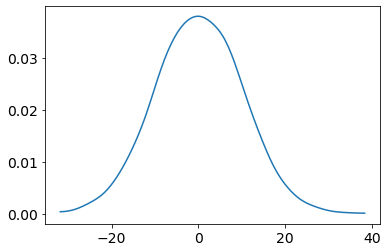

In [ ]:
az.plot_dist(posterior['w_1'][:,7,4])

In [ ]:
posterior = approx.sample(draws=10000)

xtest=scaler.transform(Xtest)
x1 = np.hstack([np.ones((1,1)),xtest])
ypred=[]
for i in range(posterior['w_1'].shape[0]):#MC posterior['w_1'].shape[0]
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x1.T))
    #outer layer
    ypred.append(np.dot(posterior['w_0'][i,:],t1))
ypred = np.array(ypred)

In [ ]:
x1

array([[ 1.        ,  0.07627655,  0.61136396,  0.89223302,  0.38904671,
         0.15903405, -1.73595199, -1.75234397]])

/home/benavoli/.local/lib/python3.6/site-packages/arviz/data/base.py:146: UserWarning: More chains (10000) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff186ee1be0>],
      dtype=object)

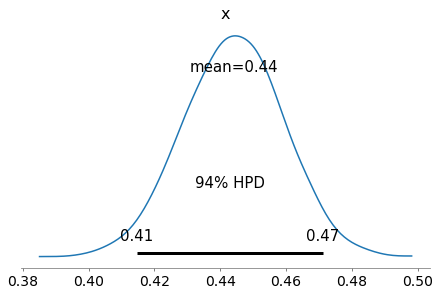

In [ ]:
import arviz as az
az.plot_posterior(ypred)